In [2]:
import umap
import umap.utils as utils
import umap.aligned_umap
import sklearn.decomposition

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import fuzz, process
import re

/opt/anaconda3/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
votes = [pd.read_csv(f"house_votes/{year}_voting_record.csv", index_col=0).sort_index()
         for year in range(1990,2021)]
metadata = [pd.read_csv(
    f"house_votes/{year}_full.csv",
    index_col=0
)[["legislator", "state", "party"]].drop_duplicates(["legislator", "state"]).sort_values('legislator')
            for year in range(1990,2021)]

In [4]:
votes[5]

,104-1st-100,104-1st-101,104-1st-102,104-1st-103,104-1st-104,104-1st-105,104-1st-106,104-1st-107,104-1st-108,104-1st-109,...,104-1st-876,104-1st-877,104-1st-878,104-1st-879,104-1st-880,104-1st-881,104-1st-882,104-1st-883,104-1st-884,104-1st-885
legislator,,,,,,,,,,,,,,,,,,,,,
Abercrombie,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,0.0,1.0
Ackerman,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Allard,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0
Andrews,0.0,-1.0,-1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0
Archer,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young (AK),1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.0
Young (FL),1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0
Zeliff,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0


In [5]:
metadata[5]

,legislator,state,party
0,Abercrombie,HI,D
1,Ackerman,NY,D
2,Allard,CO,R
3,Andrews,NJ,D
4,Archer,TX,R
...,...,...,...
430,Young (AK),AK,R
431,Young (FL),FL,R
432,Zeliff,NH,R
433,Zimmer,NJ,R


Some legislators with the same name are disambiguated with their state listed in brackets after their name. This is a complication that needs to be resolved because the disambiguation is added only in the cases the naming conflict occurs. To fix this a unique ID will be added to each legislator and groupby is used to obtain the use cases where representatives names are listed twice (un-ambigous and disambiguated).

In [7]:
def unique_legislator(row):
    name, state, party = row.legislator, row.state, row.party
    # Strip of disambiguating state designators
    if re.search(r'(\w+) \([A-Z]{2}\)', name) is not None:
        name = name[:-5]
    return f"{name} ({party}, {state})"

In [8]:
for i, _ in enumerate(votes):
    votes[i].index = pd.Index(metadata[i].apply(unique_legislator, axis=1), name="legislator_index")
    votes[i] = votes[i].groupby(level=0).sum()
    metadata[i].index = pd.Index(metadata[i].apply(unique_legislator, axis=1), name="legislator_index")
    metadata[i] = metadata[i].groupby(level=0).first()

In [9]:
votes = [
    pd.merge(
        v1, v2, how="outer", on="legislator_index"
    ).fillna(0.0).sort_index()
    for v1, v2 in zip(votes[:-1], votes[1:])
] + votes[-1:]

metadata = [
    pd.concat([m1, m2]).groupby("legislator_index").first().sort_index()
    for m1, m2 in zip(metadata[:-1], metadata[1:])
] + metadata[-1:]

In [10]:
votes = [
    pd.merge(
        v1, v2, how="outer", on="legislator_index"
    ).fillna(0.0).sort_index()
    for v1, v2 in zip(votes[:-1], votes[1:])
] + votes[-1:]

metadata = [
    pd.concat([m1, m2]).groupby(level=0).first().sort_index()
    for m1, m2 in zip(metadata[:-1], metadata[1:])
] + metadata[-1:]

In [11]:
def make_relation(from_df, to_df):
    left = pd.DataFrame(data=np.arange(len(from_df)), index=from_df.index)
    right = pd.DataFrame(data=np.arange(len(to_df)), index=to_df.index)
    merge = pd.merge(left, right, left_index=True, right_index=True)
    return dict(merge.values)

In [12]:
relations = [make_relation(x,y) for x, y in zip(votes[:-1], votes[1:])]

In [13]:
%%time
aligned_mapper = umap.aligned_umap.AlignedUMAP(
    metric="cosine",
    n_neighbors=20,
    alignment_regularisation=0.1,
    alignment_window_size=5,
    n_epochs=200,
    random_state=42,
).fit(votes, relations=relations)
embeddings = aligned_mapper.embeddings_

/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:905: RuntimeWarning: overflow encountered in true_divide
  result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]


CPU times: user 9min 8s, sys: 14.8 s, total: 9min 23s
Wall time: 7min 33s


In [15]:
election_winners = pd.read_csv('election_winners_1976-2018.csv', index_col=0)
election_winners.head()

,year,state,district,winner,party,winning_ratio
0,1976,AK,0,Don Young,republican,0.289986
0,1976,AL,1,Jack Edwards,republican,0.374808
0,1976,AL,2,"William L. \\""Bill\""\"" Dickinson""",republican,0.423953
0,1976,AL,3,Bill Nichols,democrat,1.000000
0,1976,AL,4,Tom Bevill,democrat,0.803825


In [16]:
n_name_misses = 0
for year, df in enumerate(metadata, 1990):
    df["partisan_lean"] = 0.5
    df["district"] = np.full(len(df), -1, dtype=np.int8)
    for idx, (loc, row) in enumerate(df.iterrows()):
        name, state, party = row.legislator, row.state, row.party
        # Strip of disambiguating state designators
        if re.search(r'(\w+) \([A-Z]{2}\)', name) is not None:
            name = name[:-5]
        # Get a party designator matching the election_winners data
        party = "republican" if party == "R" else "democrat"
        # Restrict to the right state and time-frame
        state_election_winners = election_winners[(election_winners.state == state)
                                                  & (election_winners.year <= year + 4)
                                                  & (election_winners.year >= year - 4)]
        # Try to match a name; and fail "gracefully"
        try:
            matched_name = process.extractOne(
                name,
                state_election_winners.winner.tolist(),
                scorer=fuzz.partial_token_sort_ratio,
                score_cutoff=50,
            )
        except:
            matched_name = None

        # If we got a unique match, get the election data
        if matched_name is not None:
            winner = state_election_winners[state_election_winners.winner == matched_name[0]]
        else:
            winner = []

        # We either have none, one, or *several* match elections. Take a best guess.
        if len(winner) < 1:
            df.loc[loc, ["partisan_lean"]] = 0.25 if party == "republican" else 0.75
            n_name_misses += 1
        elif len(winner) > 1:
            df.iloc[idx, 4] = int(winner.district.values[-1])
            df.iloc[idx, 3] = float(winner.winning_ratio.values[-1])
        else:
            df.iloc[idx, 4] = int(winner.district.values)
            df.iloc[idx, 3] = float(winner.winning_ratio.values[0])

print(f"Failed to match a name {n_name_misses} times")

Failed to match a name 91 times


In [17]:
def axis_bounds(embedding):
    left = embedding.T[0].min()
    right = embedding.T[0].max()
    bottom = embedding.T[1].min()
    top = embedding.T[1].max()
    width = right - left
    height = top - bottom
    adj_h = width * 0.1
    adj_v = height * 0.05
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

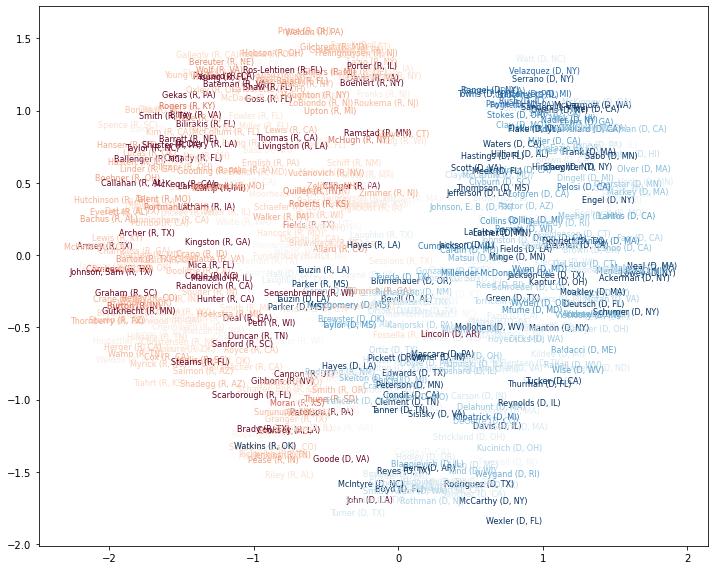

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
e = 5
ax.axis(axis_bounds(embeddings[e]))
ax.set_aspect('equal')
for i in range(embeddings[e].shape[0]):
    ax.text(embeddings[e][i, 0],
            embeddings[e][i, 1],
            metadata[e].index.values[i],
            color=plt.cm.RdBu(np.float32(metadata[e]["partisan_lean"].values[i])),
            fontsize=8,
            horizontalalignment='center',
            verticalalignment='center',
           )

In [19]:
import plotly.graph_objects as go
import scipy.interpolate

In [20]:
df = pd.DataFrame(np.vstack(embeddings), columns=('x', 'y'))
df['z'] = np.concatenate([[year] * len(embeddings[i]) for i, year in enumerate(range(1990, 2021))])
df['representative_id'] = np.concatenate([v.index for v in votes])
df['partisan_lean'] = np.concatenate([m["partisan_lean"].values for m in metadata])

In [21]:
INTERP_KIND = {2:"linear", 3:"quadratic", 4:"cubic"}

def interpolate_paths(z, x, y, c, rep_id):
    consecutive_year_blocks = np.where(np.diff(z) != 1)[0] + 1
    z_blocks = np.split(z, consecutive_year_blocks)
    x_blocks = np.split(x, consecutive_year_blocks)
    y_blocks = np.split(y, consecutive_year_blocks)
    c_blocks = np.split(c, consecutive_year_blocks)

    paths = []

    for block_idx, zs in enumerate(z_blocks):

        text = f"{rep_id} -- partisan_lean: {np.mean(c_blocks[block_idx]):.2f}"

        if len(zs) > 1:
            kind = INTERP_KIND.get(len(zs), "cubic")
        else:
            paths.append(
                (zs, x_blocks[block_idx], y_blocks[block_idx], c_blocks[block_idx], text)
            )
            continue

        z = np.linspace(np.min(zs), np.max(zs), 100)
        x = scipy.interpolate.interp1d(zs, x_blocks[block_idx], kind=kind)(z)
        y = scipy.interpolate.interp1d(zs, y_blocks[block_idx], kind=kind)(z)
        c = scipy.interpolate.interp1d(zs, c_blocks[block_idx], kind="linear")(z)

        paths.append((z, x, y, c, text))

    return paths

In [22]:
traces = []
for rep in df.representative_id.unique():
    z = df.z[df.representative_id == rep].values
    x = df.x[df.representative_id == rep].values
    y = df.y[df.representative_id == rep].values
    c = df.partisan_lean[df.representative_id == rep]

    for z, x, y, c, text in interpolate_paths(z, x, y, c, rep):
        trace = go.Scatter3d(
            x=x, y=z, z=y,
            mode="lines",
            hovertext=text,
            hoverinfo="text",
            line=dict(
                color=c,
                cmin=0.0,
                cmid=0.5,
                cmax=1.0,
                cauto=False,
                colorscale="RdBu",
                colorbar=dict(),
                width=2.5,
            ),
            opacity=1.0,
        )
        traces.append(trace)

fig = go.Figure(data=traces)
fig.update_layout(
    width=800,
    height=600,
    scene=dict(
        aspectratio = dict( x=0.5, y=1.25, z=0.5 ),
        yaxis_title="Year",
        xaxis_title="UMAP-X",
        zaxis_title="UMAP-Y",
    ),
    scene_camera=dict(eye=dict( x=0.5, y=0.8, z=0.75 )),
    autosize=False,
    showlegend=False,
)
fig_widget = go.FigureWidget(fig)
fig_widget

FigureWidget({
    'data': [{'hoverinfo': 'text',
              'hovertext': 'Abercrombie (D, HI) -- partisan_…